# Pump it Up: Data Mining the Water Table



#### Import relevant libraries

In [1]:
import modin.pandas as pd
import numpy as np
from scipy import stats
import missingno as msno
#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
#Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder #categorical to numerical data
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
#Evaluation
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
#Turning off warnings
import warnings
warnings.filterwarnings('ignore')

#### Import data

In [2]:
train_values = pd.read_csv('Training Set Values.csv')
train_labels = pd.read_csv('Training Set Labels.csv')
test_values = pd.read_csv('Test Set Values.csv')

## Workflow
#### 1. Data Interpretation
#### 2. Exploratory Data Analysis (EDA)
#### 3. Preprocessing 
#### 4. Feature Engineering
#### 5. Modelling  
#### 6. Create Predictions

## 1. Interpretación de los datos
Disponemos inicialmente de tres conjuntos de datos: 
- *train_values*, los predictores (variables independientes) con los que entrenaremos el modelo
- *train_labels*, la variable target (dependiente) con la que entrenaremos el modelo
- *test_values*, los predictores con los que validaremos el modelo y que nos darán teoricamente test_labels, que corresponden a las predicciones

Hay que tener en cuenta que aunque tengamos los datos train/test, aplicaremos luego la función train_test_split **solo sobre train_values y train_labels**.

En el siguiente paso crearemos un df nuevo, *X_all*, que contiene todos los predictors, es decir de train y test, para realizar el preprocesado en un solo paso y no para los dos conjuntos individualmente. 

In [3]:
# Combine df train_values and test_values to do preprocessing in one step
X_all = pd.concat([train_values, test_values])
print('Dimensionalidad X_all: ', X_all.shape)

Dimensionalidad X_all:  (74250, 40)


In [4]:
# Check dimensionality
print('Dimensionality train_values: ', train_values.shape,', 80% of the data')
print('Dimensionality train_labels: ', train_labels.shape)
print('Dimensionality test_values: ', test_values.shape,', 20% of the data')

Dimensionality train_values:  (59400, 40) , 80% of the data
Dimensionality train_labels:  (59400, 2)
Dimensionality test_values:  (14850, 40) , 20% of the data


#### Predictores

In [5]:
pd.options.display.max_columns = None
print(train_values.shape)
train_values.head()

(59400, 40)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [6]:
print(test_values.shape)
test_values.head()

(14850, 40)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


#### Variable target

In [7]:
print(train_labels.shape)
train_labels.head()

(59400, 2)


,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


                         Counts  Percentage
functional                32259   54.308081
non functional            22824   38.424242
functional needs repair    4317    7.267677


<AxesSubplot:>

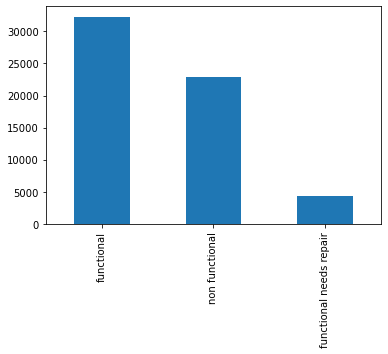

In [8]:
#Observations per category for target variable: 
print(pd.DataFrame({'Counts': train_labels['status_group'].value_counts(),
                    'Percentage': train_labels['status_group'].value_counts()/len(train_labels)*100}))

pd.value_counts(train_labels['status_group']).plot.bar()

#### Inspección variable target con algunos predictores: 

<AxesSubplot:xlabel='water_quality'>

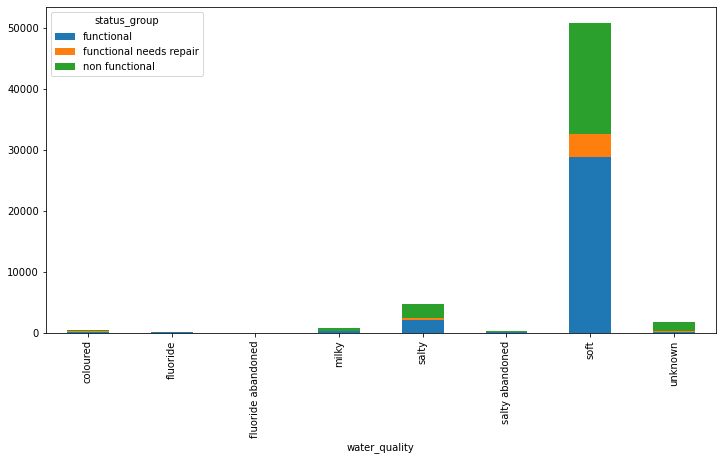

In [9]:
#water_quality vs status_group
pd.crosstab(train_values['water_quality'], train_labels['status_group']).plot.bar(stacked=True, figsize=(12,6))

<AxesSubplot:xlabel='quantity'>

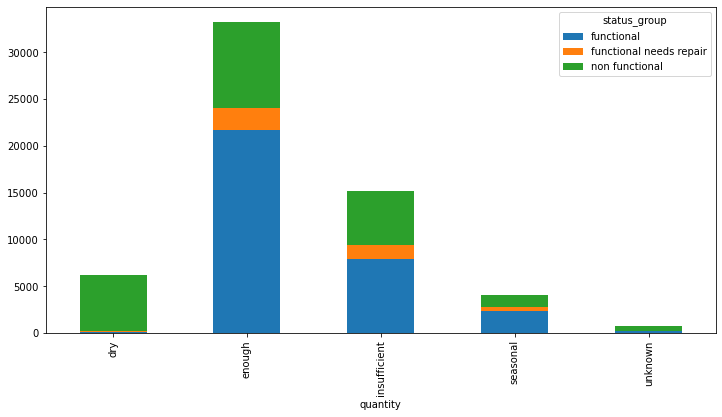

In [10]:
#quantity vs status_group
pd.crosstab(train_values['quantity'], train_labels['status_group']).plot.bar(stacked=True, figsize=(12,6))

Podemos ver que nuestro conjunto de datos consiste de 59400 filas y 40 variables independientes que analizaremos en el siguiente apartado. Seguramente podremos recudir la dimensionalidad del conjunto, ya que parece a primera vista que hay algunas variables redundantes. 
El objetivo es predecir la variable categórica **status_group** que indica la funcionalidad de las bombas en tres niveles: *'functional'*, *'non functional'* y *'functional needs repair'*. En práctica estas predicciones se podrán utilizar para darle prioridad a las bombas que necesitan reparación o que no funcionan, y asi mejorar la distribución de agua en Tanzania.


## 2. Exploratory Data Analysis (EDA)

In [11]:
X_all.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


Podemos intuir que en las variables numéricas hay algunas que tienen una distribución muy desequilibrada, como *amount_tsh*, *num_private* y *population*. En continuación veremos las distribuciones graficamente.

Por los nombres da las variables además podríamos intuir que hay algunas variables que se repiten y que son redundantes. Esto puede ser una señal que exista **colinealidad** entre las variables, que es exactamente lo que intentaremos evitar.

### 2.1 Distribuciones de las variables numéricas

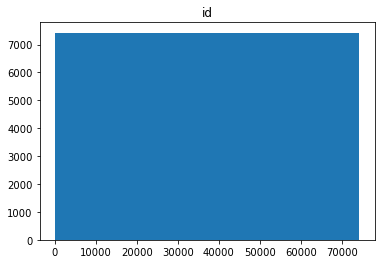

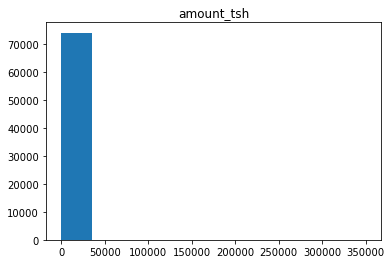

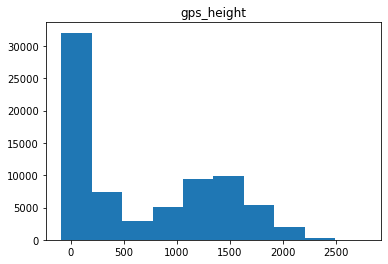

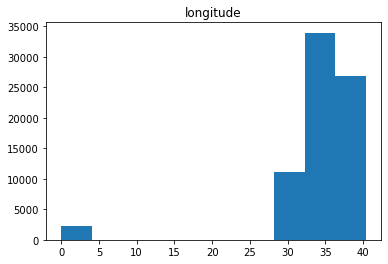

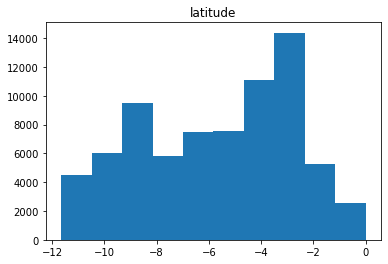

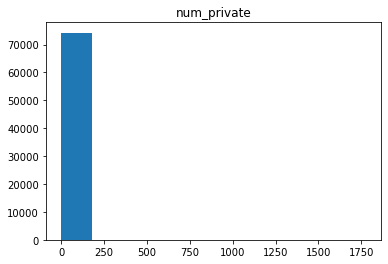

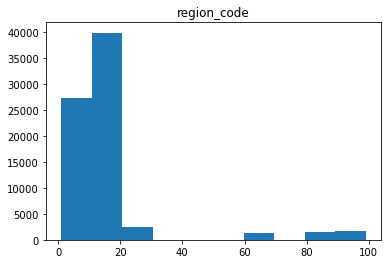

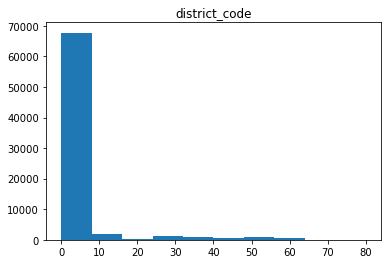

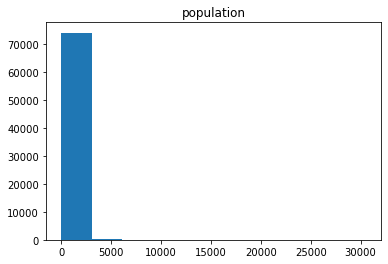

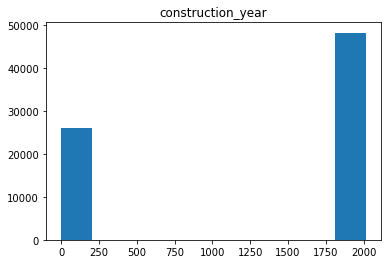

In [12]:
X_num = X_all[['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude','num_private','region_code',
                   'district_code','population','construction_year']]

for col in X_num.columns: 
    plt.hist(X_num[col])
    plt.title(col)
    plt.show()

In [17]:
# ctegorical correlation
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

0.9999663235031543

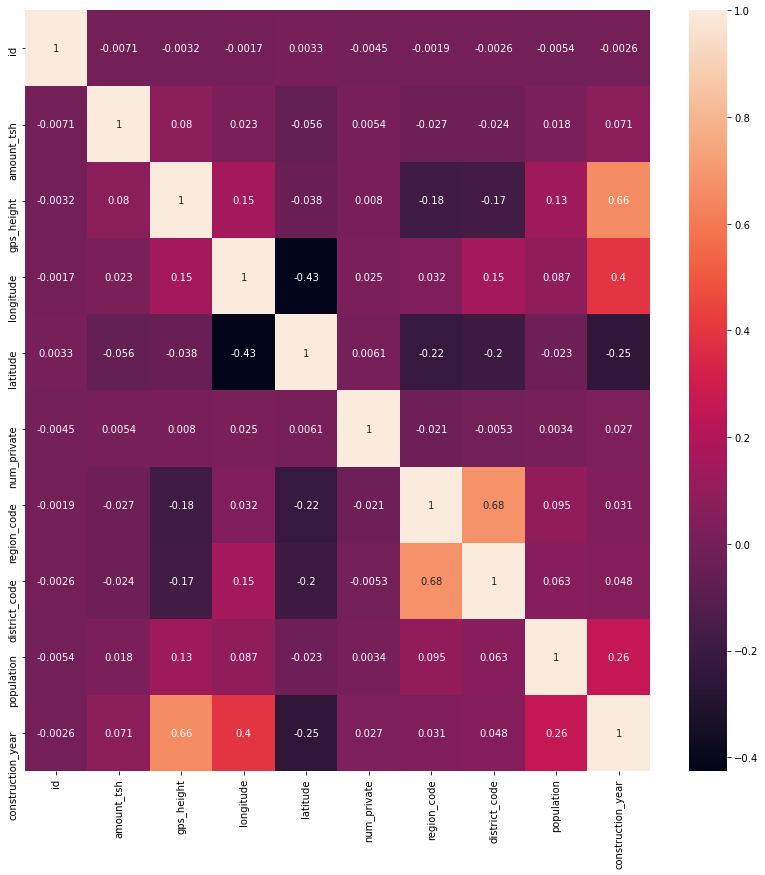

In [13]:
# numerical correlation
plt.figure(figsize=(14,14))
cor = X_all.corr()
sns.heatmap(cor, annot=True)
plt.show()

### 2.2 Variables con nombres parecidos
Hay variables con nombres muy parecidos, que probablemente son redundantes y pueden ser eliminadas.
#### 'extraction_type', 'extraction_type_group', 'extraction_type_class'

In [61]:
X_all.groupby(['extraction_type', 'extraction_type_group', 'extraction_type_class']).size()

extraction_type            extraction_type_group  extraction_type_class
afridev                    afridev                handpump                  2208
cemo                       other motorpump        motorpump                  108
climax                     other motorpump        motorpump                   41
gravity                    gravity                gravity                  33263
india mark ii              india mark ii          handpump                  3029
india mark iii             india mark iii         handpump                   135
ksb                        submersible            submersible               1790
mono                       mono                   motorpump                 3628
nira/tanira                nira/tanira            handpump                 10205
other                      other                  other                     8102
other - mkulima/shinyanga  other handpump         handpump                     2
other - play pump          other hand

- Quitamos 'extraction_type' y 'extraction_type_group'

#### 'management', 'management_group', 'scheme_management',

In [62]:
X_all.groupby(['management', 'management_group', 'scheme_management']).size()

management  management_group  scheme_management
company     commercial        Company               848
                              Private operator        2
                              Trust                   1
                              VWC                     2
                              WUA                     1
                                                   ... 
wug         user-group        VWC                  1007
                              WUA                    55
                              WUG                  5953
                              Water Board           139
                              Water authority        19
Length: 86, dtype: int64

- Quitamos 'management_group' y 'scheme_management'

#### 'payment', 'payment_type'

In [63]:
X_all.groupby(['payment', 'payment_type']).size()

payment                payment_type
never pay              never pay       31712
other                  other            1314
pay annually           annually         4570
pay monthly            monthly         10397
pay per bucket         per bucket      11266
pay when scheme fails  on failure       4842
unknown                unknown         10149
dtype: int64

-  Quitamos 'payment'

#### 'water_quality', 'quality_group'

In [64]:
X_all.groupby(['water_quality', 'quality_group']).size()

water_quality       quality_group
coloured            colored            623
fluoride            fluoride           244
fluoride abandoned  fluoride            23
milky               milky             1005
salty               salty             6082
salty abandoned     salty              423
soft                good             63505
unknown             unknown           2345
dtype: int64

- Quitamos 'quality_group'

#### 'quantity', 'quantity_group'

In [65]:
X_all.groupby(['quantity', 'quantity_group']).size()

quantity      quantity_group
dry           dry                7782
enough        enough            41522
insufficient  insufficient      18896
seasonal      seasonal           5075
unknown       unknown             975
dtype: int64

- Quitamos 'quantity_group'

#### 'source', 'source_type', 'source_class'

In [66]:
X_all.groupby(['source', 'source_type', 'source_class']).size()

source                source_type           source_class
dam                   dam                   surface           840
hand dtw              borehole              groundwater      1108
lake                  river/lake            surface           950
machine dbh           borehole              groundwater     13822
other                 other                 unknown           261
rainwater harvesting  rainwater harvesting  surface          2863
river                 river/lake            surface         11964
shallow well          shallow well          groundwater     21140
spring                spring                groundwater     21216
unknown               other                 unknown            86
dtype: int64

- Quitamos 'source_type'

#### 'waterpoint_type', 'waterpoint_type_group'

In [67]:
X_all.groupby(['waterpoint_type', 'waterpoint_type_group']).size()

waterpoint_type              waterpoint_type_group
cattle trough                cattle trough              150
communal standpipe           communal standpipe       35628
communal standpipe multiple  communal standpipe        7611
dam                          dam                          8
hand pump                    hand pump                21884
improved spring              improved spring            959
other                        other                     8010
dtype: int64

- Quitamos 'waterpoint_type_group'

Vemos que de las variables que comparamos todas tienen las mismas categorias o categorias similares, por lo cual se pueden eliminar las variables redundantes.

### 2.3 Feature Selection preliminar 
Dado que hemos observado variables redundantes, quitaremos esas variables del conjunto, para hacer la analisis posterior más simple y claro.

In [68]:
# Delete redundant variables
drop_cols = ['extraction_type', 
             'extraction_type_group',
             'management_group',
             'scheme_management',
             'payment',
             'quality_group',
             'quantity_group',
             'source_type',
             'waterpoint_type_group']

X_all.drop(drop_cols, axis=1, inplace=True)

#### Cardinalidad de cada variable

In [69]:
# Get number of unique entries in each column with categorical data
def unique_per_col(df): 
    #Selecting only categorical cols
    cols = (df.dtypes == 'object')
    object_cols = list(cols[cols].index)
    #Count unique values
    object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
    d = dict(zip(object_cols, object_nunique))
    #Print number of unique entries by column, in ascending order
    for row in sorted(d.items(), key=lambda x: x[1]):
        print(row)
    
unique_per_col(X_all)

('recorded_by', 1)
('public_meeting', 2)
('permit', 2)
('quantity', 5)
('extraction_type_class', 7)
('payment_type', 7)
('waterpoint_type', 7)
('water_quality', 8)
('basin', 9)
('source', 10)
('management', 12)
('region', 21)
('lga', 125)
('date_recorded', 369)
('ward', 2098)
('funder', 2140)
('installer', 2410)
('scheme_name', 2868)
('subvillage', 21425)
('wpt_name', 45684)


#### To-do: 
- quitar *wpt_name*, ya que tiene muchas categorias y no aportará al modelo 
- quitar *subvillage*, muchas categorias
- quitar *region*, porque region_code contiene la misma información y ya es numérica
- quitar *ward*, muchas categorias
- quitar *recorded_by*, porque solo tiene un valor (varianza = 0) y no va a aportar a mejorar la capacidad predictiva del modelo 
- quitar *lga*, muchas categorias y además tenemos los region_code para indicar la ubicación

In [70]:
# Delete cols
drop_cols = ['wpt_name', 
             'subvillage', 
             'region', 
             'ward', 
             'recorded_by',
             'lga']

X_all.drop(drop_cols, axis=1, inplace=True)

#### Correlaciones entre variables
Sospechamos que habran algunas variables correlacionadas. Las que parecen obvias como latitud y longitud, pero igual hay alguna otra variable con alta correlación que podemos quitar.

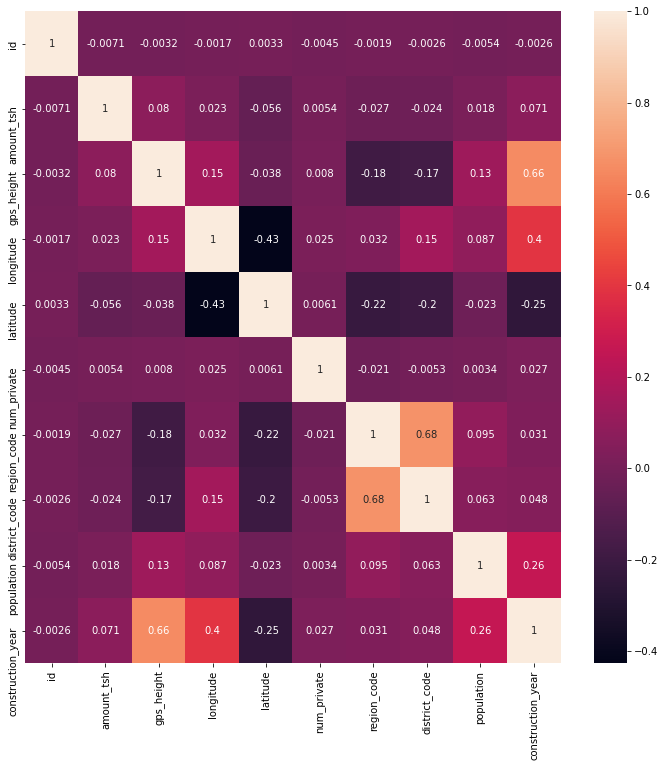

In [71]:
plt.figure(figsize=(12,12))
cor = X_all.corr()
sns.heatmap(cor, annot=True)
plt.show()

In [72]:
# Efectivamente hay una alta correlación entre district_code y region_code.
# Quitamos la que más categorias tiene: 
X_all.drop('region_code', axis=1, inplace=True)

## 3. Preprocesado
### 3.1 Valores missing

,variable,Unique values,Nan %,zeros %
13,scheme_name,2869,47.5,0.0
3,funder,2141,6.1,0.0
5,installer,2411,6.1,0.0
12,public_meeting,3,5.6,8.5
14,permit,3,5.1,29.4
0,id,74250,0.0,0.0
21,source,10,0.0,0.0
20,quantity,5,0.0,0.0
19,water_quality,8,0.0,0.0
18,payment_type,7,0.0,0.0


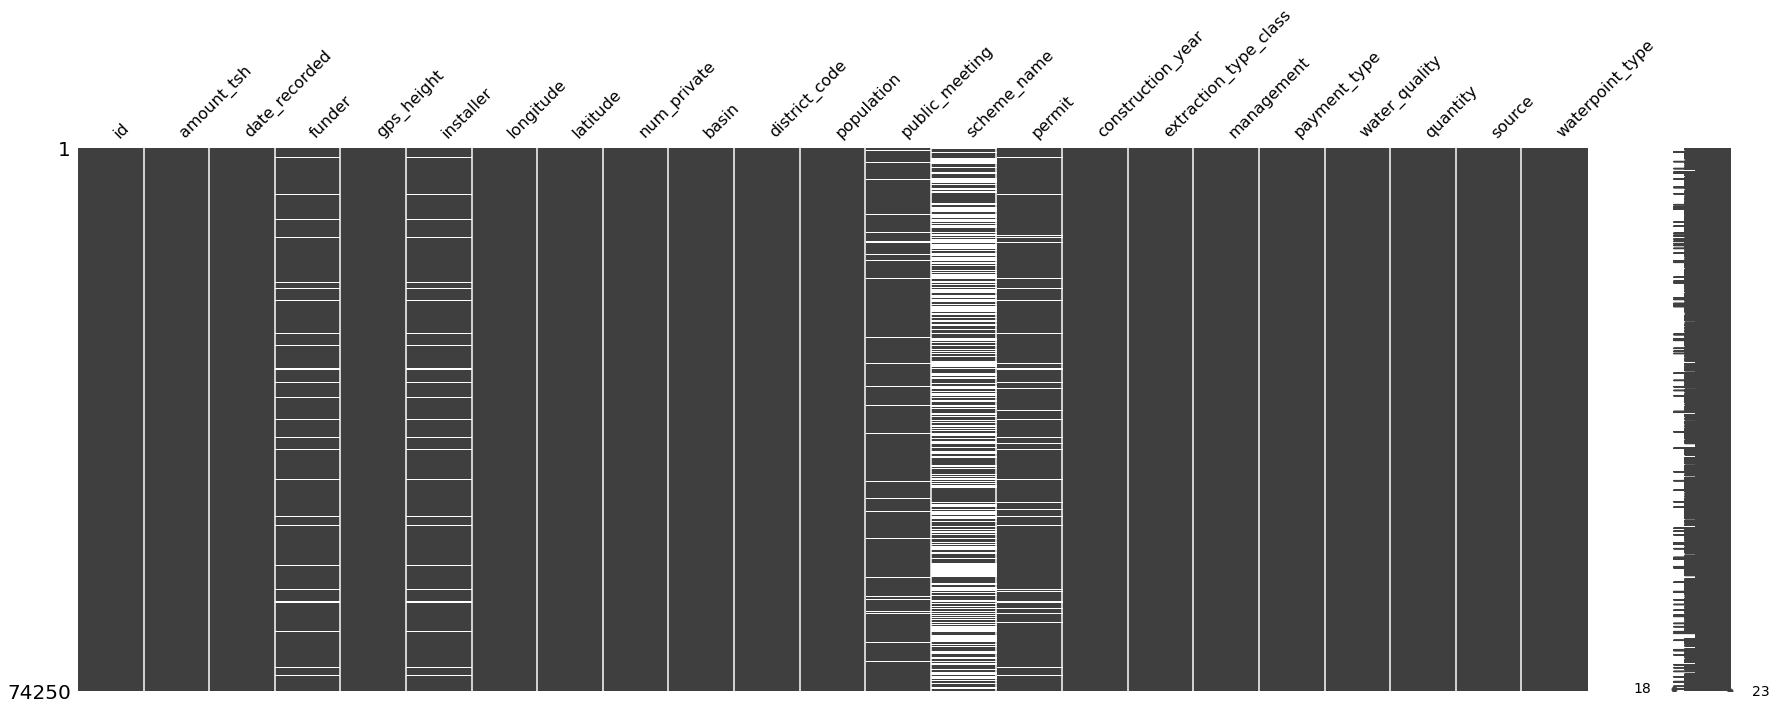

In [73]:
# Plot missing values
msno.matrix(X_all, figsize = (30,10))

def missing_values(data):
    df = pd.DataFrame()
    for col in list(data):
        unique_values = data[col].unique()
        try:
            unique_values = np.sort(unique_values)
        except:
            pass
        nans = round(pd.isnull(data[col]).sum()/data.shape[0]*100, 1)
        zeros = round((data[col] == 0).sum()/data.shape[0]*100, 1)
        #empty = round((data[data[col]] == '').sum()/data.shape[0]*100, 1)
        df = df.append(pd.DataFrame([col,
                                     len(unique_values),
                                     nans,
                                     zeros,
                                     #empty
                                    ]).T, ignore_index = True)

    return df.rename(columns = {0: 'variable',
                                1: 'Unique values',
                                2: 'Nan %',
                                3: 'zeros %',
                                #4: 'empty'
                               }).sort_values('Nan %', ascending=False)

missing_values(X_all)

Vemos que hay muchas variables que tienen valores faltantes codificados como *NaN* y otros que tienen valores codificado con 0, que se pueden considerar valores faltantes también. <br>
Iremos viendo por variable detalladamente que podemos hacer para corregir los valores.

#### scheme_name
El porcentaje de valores faltantes de esta variable es muy superior a lo que sería razonable para imputar valores, sobre todo dado que hay más que 2800 categorias. Por lo tanto quitaremos esa variable.

In [74]:
X_all.drop('scheme_name', axis=1, inplace=True)

#### management, funder, installer, public_meeting, permit
Estas variables tienen un porcentaje de missings mucho más bajo y por lo cual podemos imputarlos con la moda. 

In [75]:
# Impute with mode
X_all['management'].fillna(X_all['management'].mode()[0], inplace=True)
X_all['funder'].fillna(X_all['funder'].mode()[0], inplace=True)
X_all['installer'].fillna(X_all['installer'].mode()[0], inplace=True)
X_all['public_meeting'].fillna(X_all['public_meeting'].mode()[0], inplace=True)
X_all['permit'].fillna(X_all['permit'].mode()[0], inplace=True)

### 3.2 Ceros 
#### num_private
Vemos que 98,7% de esta variable son 0, por lo cual sabemos que no nos va a ayudar a discriminar contra la variable objetivo y la eliminamos.

In [76]:
# drop num_private 
X_all.drop('num_private', axis=1, inplace=True)

#### construction_year

In [77]:
# Distribution without 0 for construction_year
X_all.loc[X_all['construction_year']!=0].describe()

,id,amount_tsh,gps_height,longitude,latitude,district_code,population,construction_year
count,48281.000000,48281.000000,48281.000000,48281.000000,48281.000000,48281.000000,48281.000000,48281.000000
mean,37084.269609,469.739275,1000.202709,35.986840,-6.237147,5.967006,271.572233,1996.870943
std,21411.638110,3456.533934,618.538809,2.559941,2.760997,10.709279,552.329367,12.440524
min,1.000000,0.000000,-63.000000,29.607122,-11.649440,1.000000,0.000000,1960.000000
25%,18512.000000,0.000000,369.000000,34.676387,-8.744394,2.000000,30.000000,1988.000000
50%,37097.000000,0.000000,1153.000000,36.653857,-6.078797,3.000000,150.000000,2000.000000
75%,55548.000000,200.000000,1486.000000,37.814225,-3.654467,5.000000,312.000000,2008.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-1.042375,63.000000,30500.000000,2013.000000


In [78]:
# replace with median
median_yr = X_all['construction_year'].median()
X_all['construction_year'] = X_all['construction_year'].replace(0, median_yr)
X_all['construction_year'] = X_all['construction_year'].astype(int)

#### population

In [79]:
# replace with median
median_pop = X_all['population'].median()
X_all['population'] = X_all['population'].replace(0, median_pop)

#### longitud

In [80]:
# replace with median
median_lon = X_all['longitude'].median()
X_all['longitude'] = X_all['longitude'].replace(0, median_lon)

#### amount_tsh

In [81]:
# eliminate due to high % of zeros
X_all.drop('amount_tsh', axis=1, inplace=True)

## 4. Feature Engineering

### 4.1 Encoding variables categóricas
El problema que enfrentamos con algunas de las variables categóricas es la alta cardinalidad, es decir el alto número de valores únicos (o categorias).<br> A parte de esto nos suponen problemas cada manera de codificar las variables: 
- si usamos *mapping*, es decir asignar un valor numérico a cada variable, inferimos un orden a las categorias (por ejemplo 4 > 1 o 2x2 = 4), cuando no necesariamente existe un orden en las categorias
- si usamos *dummy variables* o *one hot encoding*, aumentamos la dimensionalidad por n-1, con n siendo las categorias. Por lo cual no podemos usar este método con variables de alta cardinalidad <br>

Aplicaremos un modo adecuado para cada variable: 
- Para las variables booleanas usaremos el mapping para asignarle 0 o 1. 
- Para las variables con hasta 12 categorias usaremos label encoding
- La variable date_recorded la podemos dividir facilmente en año, mes y día
- Para las variables *funder* e *installer* agruparemos las categorias con más datos y usaremos label encoding

In [82]:
X_all_cat = X_all[['date_recorded', 'funder', 'installer', 'basin', 'public_meeting',
                   'permit', 'extraction_type_class', 'management', 'payment_type', 'water_quality', 'quantity',
                   'source', 'waterpoint_type']]

print('Unique values per category:'); print('='*len('Unique values per category:'))
for var in X_all_cat.columns: 
    print(var, len(X_all_cat[var].value_counts()))

Unique values per category:
date_recorded 369
funder 2140
installer 2410
basin 9
public_meeting 2
permit 2
extraction_type_class 7
management 12
payment_type 7
water_quality 8
quantity 5
source 10
waterpoint_type 7


#### 4.1.1. Encoding variables booleanas usando mapping:

In [83]:
# permit
X_all['permit'].unique()
X_all['permit'] = X_all['permit'].map( {False: 0, True: 1} ).astype(int)

# public meeting
X_all['public_meeting'].unique()
X_all['public_meeting'] = X_all['public_meeting'].map( {False: 0, True: 1} ).astype(int)

In [88]:
X_all['payment_type'].value_counts()/len(X_all['payment_type'])*100

1    42.709764
2    15.173064
6    14.002694
3    13.668687
4     6.521212
0     6.154882
5     1.769697
Name: payment_type, dtype: float64

#### 4.1.2. Encoding variables con hasta 12 categorias usando label encoding: 

In [87]:
char_cols = X_all.dtypes.pipe(lambda x: x[x == 'object']).index
char_cols = char_cols.drop(['funder', 'installer'])
label_mapping = {}

for col in char_cols:
    X_all[col], label_mapping[col] = pd.factorize(X_all[col])

#### 4.1.3. Encoding variables con alta cardinalidad (más de 12 categorias)
##### 'installer'

In [48]:
# unique values 
X_all['installer'].value_counts()/len(X_all['installer'])*100

59.51111111111111
35.3979797979798
3.0734006734006734
2.0175084175084175


In [41]:
# Keep first three labels and collapse the rest
categories_to_keep = X_all['installer'].value_counts().index[:3] 

X_all.loc[
    (~X_all.installer.isin(categories_to_keep)), 'installer'
] = 'Other'

# Label Encoding
label_mapping = {}
X_all['installer'], label_mapping['installer'] = pd.factorize(X_all['installer'])

##### 'funder'

In [42]:
# unique values
X_all['funder'].value_counts()/len(X_all['funder'])*100

Government Of Tanzania    21.283502
Danida                     5.261953
Hesawa                     3.746801
Rwssp                      2.293603
World Bank                 2.290909
                            ...    
Tanzania Compasion         0.001347
Tgz                        0.001347
Upper Ruvu                 0.001347
Kikundi Cha Akina Mama     0.001347
Mp Mloka                   0.001347
Name: funder, Length: 2140, dtype: float64

In [43]:
# Keep first seven labels and collapse the rest
categories_to_keep = X_all['funder'].value_counts().index[:7]

X_all.loc[
    (~X_all.funder.isin(categories_to_keep)), 'funder'
] = 'Other'

# Label Encoding
label_mapping = {}
X_all['funder'], label_mapping['funder'] = pd.factorize(X_all['funder'])

### 4.2 Encoding variable target

In [44]:
# Create copy of train_labels
y = train_labels.copy()

print('Unique values in status_group: ', y['status_group'].unique())
y.head()

Unique values in status_group:  ['functional' 'non functional' 'functional needs repair']


,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [45]:
# Encoding status_group
y['status_group'] = y['status_group'].map( {'non functional': 0,
                                            'functional needs repair': 1,
                                            'functional': 2} ).astype(int)

In [46]:
X_all.head()

,id,date_recorded,funder,gps_height,installer,longitude,latitude,basin,district_code,population,public_meeting,permit,construction_year,extraction_type_class,management,payment_type,water_quality,quantity,source,waterpoint_type
0,69572,0,0,1390,0,34.938093,-9.856322,0,5,109.0,1,0,1999,0,0,0,0,0,0,0
1,8776,1,0,1399,0,34.698766,-2.147466,1,2,280.0,1,1,2010,0,1,1,0,1,1,0
2,34310,2,0,686,0,37.460664,-3.821329,2,4,250.0,1,1,2009,0,0,2,0,0,2,1
3,67743,3,0,263,0,38.486161,-11.155298,3,63,58.0,1,1,1986,1,0,1,0,2,3,1
4,19728,4,0,0,0,31.130847,-1.825359,1,1,25.0,1,1,1986,0,2,1,0,3,1,0


### 4.3 New Variables
#### 4.3.1 Payment as binary 
We'll create a new variable for payment, as binary, i.e. if there *is* a payment or if there *is not* a payment. 

In [92]:
X_all['is paid'] = X_all['payment_type'].replace({1: 0,
                                                  0: 1,
                                                  2: 1,
                                                  3: 1,
                                                  4: 1, 
                                                  5: 1,
                                                  6: 1})

,id,date_recorded,funder,gps_height,installer,longitude,latitude,basin,district_code,population,public_meeting,permit,construction_year,extraction_type_class,management,payment_type,water_quality,quantity,source,waterpoint_type,is paid
0,69572,0,Roman,1390,Roman,34.938093,-9.856322,0,5,109.0,1,0,1999,0,0,0,0,0,0,0,1
1,8776,1,Grumeti,1399,GRUMETI,34.698766,-2.147466,1,2,280.0,1,1,2010,0,1,1,0,1,1,0,0
2,34310,2,Lottery Club,686,World vision,37.460664,-3.821329,2,4,250.0,1,1,2009,0,0,2,0,0,2,1,1
3,67743,3,Unicef,263,UNICEF,38.486161,-11.155298,3,63,58.0,1,1,1986,1,0,1,0,2,3,1,0
4,19728,4,Action In A,0,Artisan,31.130847,-1.825359,1,1,25.0,1,1,1986,0,2,1,0,3,1,0,0


#### 4.3.2 Decomposition *date_recorded*
La variable date_recorded no nos ayuda mucho en su forma actual, por lo cual la vamos a decomponer en sus elementos, es decir en año, mes y día.

In [321]:
from datetime import date
# Transform string to date
X_all['date_recorded'] = pd.to_datetime(X_all['date_recorded'], format="%Y-%m-%d")
# Extracting year
X_all['year_recorded'] = X_all['date_recorded'].dt.year
# Extracting month
X_all['month_recorded'] = X_all['date_recorded'].dt.month
# Extracting tday
X_all['day_recorded'] = X_all['date_recorded'].dt.day
# Drop date_recorded
X_all.drop('date_recorded', axis=1, inplace=True)

#### Create *decade* from construction year

In [ ]:
X_all['decade'] = []

for observation in X_all['construction_year']:
    if observation 

## 5. Modelización
Intentaremos la modelización con diferentes algoritmos y computaremos la capacidad prectiva con validación cruzada. 

In [322]:
# Seperate train from test data
X = X_all[:59400]
print('Length X: ', len(X))
X.set_index('id', inplace=True)

test_values_clean = X_all[59400:]
print('Length test_values_clean:', len(test_values_clean))
test_values_clean.set_index('id', inplace=True)

print('Length y:', len(y))
y.set_index('id', inplace=True)

Length X:  59400
Length test_values_clean: 14850
Length y: 59400


In [323]:
# Create train_data 
train_data = pd.concat([X, y], axis=1)

### Eliminar Outliers en train_data
#### population

<AxesSubplot:xlabel='population'>

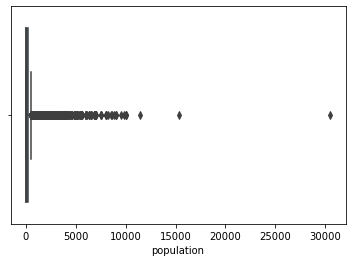

In [324]:
sns.boxplot(x=train_data['population'])

In [325]:
print('Number of outliers above 40000:', len(train_data[train_data['population'] > 40000]))
outliers_population = train_data['population'][train_data['population'] > 40000]
population_median = train_data['population'].median()

for value in outliers_population:
    train_data['population'] = train_data['population'].replace(value, population_median)

print(population_median,
     outliers_population)



Number of outliers above 40000: 0
25.0 Series([], Name: population, dtype: float64)


### 5.1 Modelos 
Usaremos diferentes algoritmos de clasificación y compararemos las precisiones (*accuracy*) con validación cruzada. <br>
Dado que en la competición se usará *classification accuracy* como metrica principal para la evaluación, nos enfocaremos principalmente en ella.

In [326]:
X = train_data.drop('status_group', axis=1)
y = train_data['status_group']

#Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
                        X,
                        y,
                        test_size=0.2, 
                        random_state=42,
                        stratify = y)

#### 5.1.1. kNN

Cross-validated Accuracy: 
0.6722895622895623

      
Accuracy:
TRAIN: 0.8308712121212121
TEST: 0.7535353535353535


<AxesSubplot:title={'center':'Confusion Matrix'}>

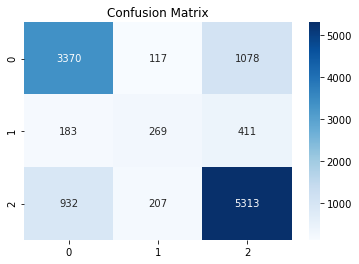

In [327]:
#Scale Data 
from sklearn.preprocessing import StandardScaler
normalized_X_train = pd.DataFrame(StandardScaler().fit_transform(X_train), columns = X_train.columns)
normalized_X_test = pd.DataFrame(StandardScaler().fit_transform(X_test), columns = X_test.columns)

#Create model
knn = KNeighborsClassifier() #creating the model
knn.fit(normalized_X_train, y_train) #showing our model the training data
y_knn_train = knn.predict(normalized_X_train) #predictions on training set
y_knn_test = knn.predict(normalized_X_test) #predictions on test set

#CV Score
y_knn_cv = cross_val_score(knn, X, y, cv=5, scoring='accuracy')

##################
#Print results
##################
##CV Accuracy
print('Cross-validated Accuracy: '); print("="*len("Cross-validated Accuracy:")); print(y_knn_cv.mean())
print('''
      ''')
##Accuracy for train and test
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_knn_train)}")
print(f"TEST: {accuracy_score(y_test, y_knn_test)}")
##Confusion Matrix
cm = confusion_matrix(y_test, y_knn_test)
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')

#### 5.1.2. Decision Tree

Cross-validated Accuracy: 
0.7502861952861954

      
Accuracy:
TRAIN: 0.9953914141414142
TEST: 0.7598484848484849


<AxesSubplot:title={'center':'Confusion Matrix'}>

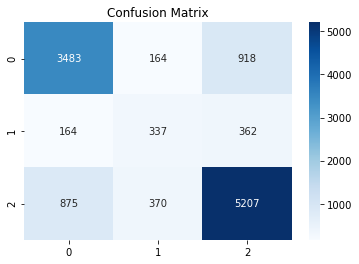

In [328]:
dt = DecisionTreeClassifier().fit(X_train, y_train) 
y_dt_train = dt.predict(X_train)
y_dt_test = dt.predict(X_test)

#CV Score
y_dt_cv = cross_val_score(dt, X, y, cv=5, scoring='accuracy')

##################
#Print results
##################
##CV Accuracy
print('Cross-validated Accuracy: '); print("="*len("Cross-validated Accuracy:")); print(y_dt_cv.mean())
print('''
      ''')
##Accuracy for train and test
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_dt_train)}")
print(f"TEST: {accuracy_score(y_test, y_dt_test)}")
##Confusion Matrix
cm = confusion_matrix(y_test, y_dt_test)
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')

#### 5.1.3. Random Forest

Cross-validated Accuracy: 
0.8035690235690236

      
Accuracy:
TRAIN: 0.9953703703703703
TEST: 0.8073232323232323


<AxesSubplot:title={'center':'Confusion Matrix'}>

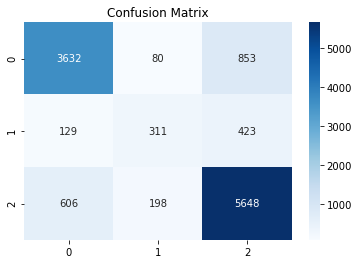

In [329]:
rf = RandomForestClassifier().fit(X_train, y_train) 
y_rf_train = rf.predict(X_train)
y_rf_test = rf.predict(X_test)

#CV Score
y_rf_cv = cross_val_score(rf, X, y, cv=5, scoring='accuracy')

##################
#Print results
##################
##CV Accuracy
print('Cross-validated Accuracy: '); print("="*len("Cross-validated Accuracy:")); print(y_rf_cv.mean())
print('''
      ''')
##Accuracy for train and test
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_rf_train)}")
print(f"TEST: {accuracy_score(y_test, y_rf_test)}")
##Confusion Matrix
cm = confusion_matrix(y_test, y_rf_test)
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')

#### 5.1.4. Gradient Boosting

Cross-validated Accuracy: 
0.7491414141414141

      
Accuracy:
TRAIN: 0.7519781144781145
TEST: 0.7489057239057239


<AxesSubplot:title={'center':'Confusion Matrix'}>

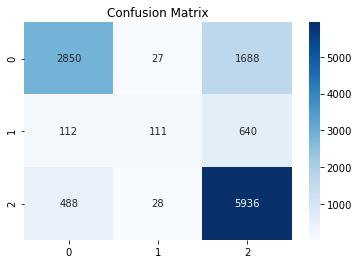

In [330]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier().fit(X_train, y_train) 
y_gb_train = gb.predict(X_train)
y_gb_test = gb.predict(X_test)

#CV Score
y_gb_cv = cross_val_score(gb, X, y, cv=5, scoring='accuracy')

##################
#Print results
##################
##CV Accuracy
print('Cross-validated Accuracy: '); print("="*len("Cross-validated Accuracy:")); print(y_gb_cv.mean())
print('''
      ''')
##Accuracy for train and test
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_gb_train)}")
print(f"TEST: {accuracy_score(y_test, y_gb_test)}")
##Confusion Matrix
cm = confusion_matrix(y_test, y_gb_test)
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')

#### 5.1.5. Bernoulli NB

Cross-validated Accuracy:
0.5960437710437709

      
Accuracy:
TRAIN: 0.5974747474747475
TEST: 0.591919191919192


<AxesSubplot:title={'center':'Confusion Matrix'}>

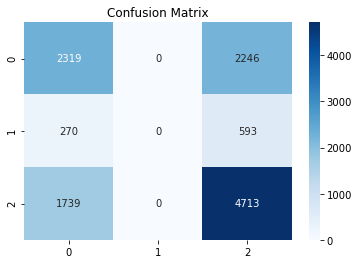

In [331]:
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB().fit(X_train, y_train) 
y_nb_train = nb.predict(X_train)
y_nb_test = nb.predict(X_test)

#CV Score
y_nb_cv = cross_val_score(nb, X, y, cv=5, scoring='accuracy')

##################
#Print results
##################
##CV Accuracy
print('Cross-validated Accuracy:'); print("="*len("Cross-validated Accuracy:")); print(y_nb_cv.mean())
print('''
      ''')
##Accuracy for train and test
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_nb_train)}")
print(f"TEST: {accuracy_score(y_test, y_nb_test)}")
##Confusion Matrix
cm = confusion_matrix(y_test, y_nb_test)
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')

#### 5.1.6. Adaboost

Cross-validated Accuracy:
0.722037037037037

      
Accuracy:
TRAIN: 0.7203703703703703
TEST: 0.718013468013468


<AxesSubplot:title={'center':'Confusion Matrix'}>

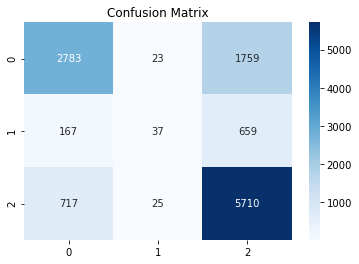

In [332]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(random_state=0).fit(X_train, y_train)
y_ada_train = ada.predict(X_train)
y_ada_test = ada.predict(X_test)

#CV Score
y_ada_cv = cross_val_score(ada, X, y, cv=5, scoring='accuracy')

##################
#Print results
##################
##CV Accuracy
print('Cross-validated Accuracy:'); print("="*len("Cross-validated Accuracy:")); print(y_ada_cv.mean())
print('''
      ''')
##Accuracy for train and test
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_ada_train)}")
print(f"TEST: {accuracy_score(y_test, y_ada_test)}")
##Confusion Matrix
cm = confusion_matrix(y_test, y_ada_test)
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')

#### Comparación modelos

In [333]:
comparison_cv = pd.DataFrame({
    'Model':[
        'kNN',
        'Decision Tree', 
        'Random Forest',
        'Gradient Boosting', 
        'Gaussian NB',
        'AdaBoost'
    ], 
    'Cross-validated accuracy':[
        y_knn_cv.mean(),
        y_dt_cv.mean(),
        y_rf_cv.mean(),
        y_gb_cv.mean(),
        y_nb_cv.mean(),
        y_ada_cv.mean()
    ]
})

print('--- Comparison cross-validated accuracy---')
print('='*len('--- Comparison cross-validated accuracy---'))
comparison_cv.sort_values('Cross-validated accuracy', ascending = False)

--- Comparison cross-validated accuracy---


,Model,Cross-validated accuracy
2,Random Forest,0.803569
1,Decision Tree,0.750286
3,Gradient Boosting,0.749141
5,AdaBoost,0.722037
0,kNN,0.672290
4,Gaussian NB,0.596044


### 5.2 Parameter Tuning
Modificaremos los parametros para el mejor modelo, que en este caso fue el Random Forest. 
Si comparamos los resultados para training y test vemos que hay un poco de sobreajuste e intentaremos disminuir este efecto con la modificación con los hyperparametros del modelo. 
#### Usando GridSearch
Con GridSearch creamos un red o selección con diferentes hyperparametros que queremos probar.
GridSearchCV calcula todas las diferentes combinaciones de los parametros que hemos especificado en la selección y así podemos calcular la precisón con validación cruzada (en este caso 3-fold CV).

In [273]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [15,20,25],
    'max_features': [4,6,8],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [4,6,8],
    'n_estimators': [300, 400, 500]
}
# Create a base model
rf = RandomForestClassifier()
# Instantiate grid search model
rf_gridsearch = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [274]:
# Fit the grid search to the data
rf_gridsearch.fit(X_train, y_train) 
rf_gridsearch.best_params_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


{'bootstrap': True,
 'max_depth': 25,
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 500}

In [275]:
# print prediction results 
predictions = rf_gridsearch.predict(X_test) 

# Accuracy for test
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TEST: {accuracy_score(y_test, predictions)}")

Accuracy:
TEST: 0.8121212121212121


## 6 Crear predicciones

In [276]:
# use test_values_clean to create the submission file
predictions_submission = rf_gridsearch.predict(test_values_clean)

submission = pd.DataFrame()
submission['id'] = test_values_clean.index.values
submission['status_group'] = predictions_submission
# replace int with string labels
replacements = {
   'status_group': {
      0: 'non functional',
      1: 'functional needs repair',
      2: 'functional'}
}

submission.replace(replacements, inplace=True)

submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [277]:
# check if both dataframes are the same length
len(test_values_clean) == len(submission)

True

In [278]:
# Save as csv file
submission.to_csv('submission.csv', index=False)

### 6.2 Evaluación
Depués de subir las predicciones, vemos que el modelo tiene una precisión de 81,35%. 
Es decir si tenemos 100 nuevas observaciones, el modelo va a clasificar aproximadamente 81 observaciones correctamente. 

![Submission](submission.png)